# Libraries

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import numpy as np
import os

# Import Data

In [2]:
path_to_data = os.path.join(os.path.dirname(os.getcwd()), 'steam-games-dataset', 'games.json')
steam_game = pd.read_json(path_to_data, orient='index')

# Data Exploration

In [3]:
# Convert date using mixed format: there are some dates that are just month/year, so format = mixed
steam_game['release_date'] = pd.to_datetime(steam_game['release_date'], format = 'mixed')

# Get only games that have been released
steam_game = steam_game[steam_game['release_date'] < "2024-01-01"]

We only want released games, so I'm filtering out all games in steam that are going to be released in 2025

### Missing Data

In [4]:
steam_game.head(2)

,name,release_date,required_age,price,dlc_count,detailed_description,about_the_game,short_description,reviews,header_image,...,score_rank,positive,negative,estimated_owners,average_playtime_forever,average_playtime_2weeks,median_playtime_forever,median_playtime_2weeks,peak_ccu,tags
20200,Galactic Bowling,2008-10-21,0,19.99,0,Galactic Bowling is an exaggerated and stylize...,Galactic Bowling is an exaggerated and stylize...,Galactic Bowling is an exaggerated and stylize...,,https://cdn.akamai.steamstatic.com/steam/apps/...,...,,6,11,0 - 20000,0,0,0,0,0,"{'Indie': 22, 'Casual': 21, 'Sports': 21, 'Bow..."
655370,Train Bandit,2017-10-12,0,0.99,0,THE LAW!! Looks to be a showdown atop a train....,THE LAW!! Looks to be a showdown atop a train....,THE LAW!! Looks to be a showdown atop a train....,,https://cdn.akamai.steamstatic.com/steam/apps/...,...,,53,5,0 - 20000,0,0,0,0,0,"{'Indie': 109, 'Action': 103, 'Pixel Graphics'..."


In [5]:
steam_game[steam_game['score_rank']!= '']['score_rank'].value_counts()

score_rank
99     18
98     12
100    12
97      2
Name: count, dtype: int64

In [6]:
steam_game[steam_game['reviews']!= '']['reviews'][1026420]

"“New WW2 Strategy Game Offers A Harrowing Look At Poland's Ill-Fated 1944 Uprising” GameSpot “(…) in execution Warsaw manages to deliver its own experience entirely.” Dualshockers “(…) Beautiful hand-painted artwork and turn-based combat (…)” Gameinformer "

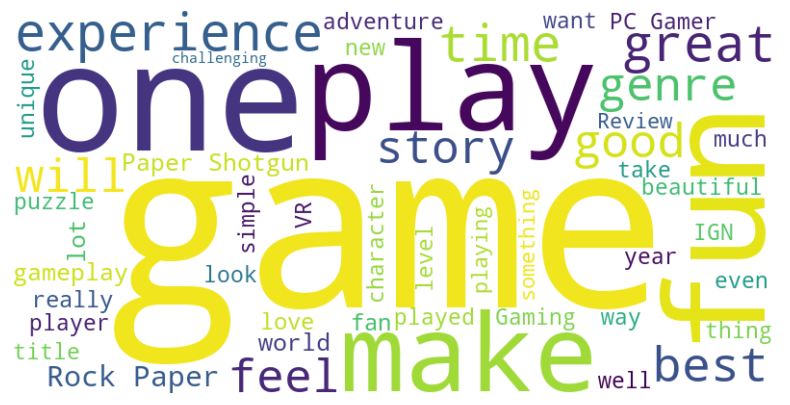

In [7]:
wordcloud_ser = steam_game[steam_game['reviews'] != '']['reviews'].str.replace(r'[^\'\w\s-]', '', regex = True)
wordcloud_text = ' '.join(wordcloud_ser)
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap = 'viridis', max_words = 50, normalize_plurals=True).generate(wordcloud_text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [8]:
# Initialize analyzer
analyzer = SentimentIntensityAnalyzer()
scores = []

# Analyze text
for text in wordcloud_ser:
    scores.append(analyzer.polarity_scores(text)['compound'])

np.mean(scores)

np.float64(0.6261858917753362)

In [9]:
wordcloud_df = wordcloud_ser.to_frame()
wordcloud_df['scores'] = scores
wordcloud_df = wordcloud_df.merge(steam_game[['release_date']], left_index=True, right_index=True)
wordcloud_df['year'] = wordcloud_df['release_date'].dt.year
sent_score = wordcloud_df.groupby('year')['scores'].mean().reset_index()
sent_score = sent_score[sent_score['year'] > 2000]

<Figure size 1000x500 with 0 Axes>

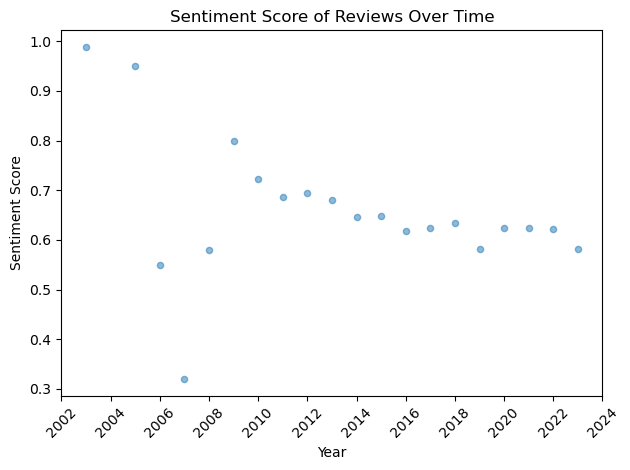

In [10]:
# Plot sentiment over years
plt.figure(figsize=(10, 5))
sent_score.plot(kind='scatter', x='year', y='scores', alpha=0.5)
plt.xlabel('Year')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Score of Reviews Over Time')

# Fix overlapping year labels
plt.xticks(rotation=45)  # Rotate labels 45 degrees
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(2))  # Show every 2nd year
plt.tight_layout()  # Adjust layout to prevent label cutoff

plt.show()

In [11]:
steam_game[steam_game['packages'].apply(lambda x: x != [])]['packages'].head(2)

20200     [{'title': 'Buy Galactic Bowling', 'descriptio...
655370    [{'title': 'Buy Train Bandit', 'description': ...
Name: packages, dtype: object

In [12]:
steam_game[steam_game['packages'].apply(lambda x: x != [])]['packages'][20200]

[{'title': 'Buy Galactic Bowling',
  'description': '',
  'subs': [{'text': 'Galactic Bowling - $19.99',
    'description': '',
    'price': 19.99}]}]

In [13]:
steam_game['required_age'].value_counts()

required_age
0     83188
17      920
18      332
13      204
16       68
10       35
12       34
3         8
15        8
7         7
6         6
14        6
21        5
20        2
5         1
1         1
19        1
9         1
11        1
Name: count, dtype: int64

In [14]:
steam_game[steam_game.notes != '']['notes']

1139950    This Game may contain content not appropriate ...
1097880    This game depicts sexual acts between the play...
1177420    This Game may contain content not appropriate ...
1192900    Iron Rebellion has elements of sci-fi combat w...
1056520    Please note that Who We Are Now contains expli...
                                 ...                        
2528400                                     Shooting enemies
2602450    A typical single-player action-roguelike atmos...
2552740                 Gameplay has shooter themed violence
2703030             Readers may be sensitive to some topics.
528940                               Blood, Gore and nudity.
Name: notes, Length: 12970, dtype: object

In [15]:
steam_game[['release_date', 'user_score']].isna().value_counts()

release_date  user_score
False         False         84828
Name: count, dtype: int64

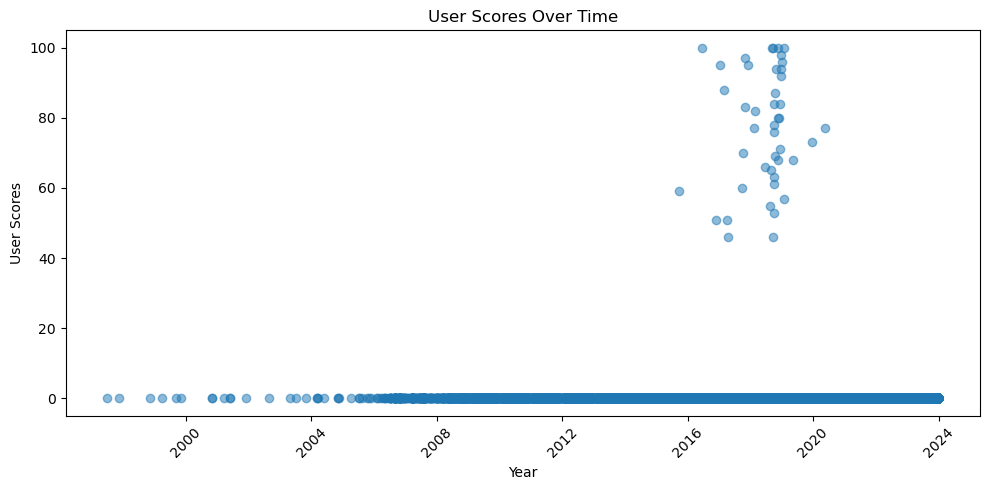

In [16]:
# Plot sentiment over years
plt.figure(figsize=(10, 5))
plt.scatter(steam_game['release_date'], steam_game['user_score'], alpha=0.5)
plt.xlabel('Year')
plt.ylabel('User Scores')
plt.title('User Scores Over Time')

# Fix overlapping year labels
plt.xticks(rotation=45)  # Rotate labels 45 degrees
plt.tight_layout()  # Adjust layout to prevent label cutoff

plt.show()

I'm dropping the URL columns, as well as the following columns:
- `score_rank`: Only had 44 values that were non-empty
- `reviews`: Very messy and only 10,0011 were filled out. This seems to be scraped steam curator reviews, but only the "headline" of some of the reviews are revealed. The problem is that Steam Curator reviews don't seem to be a good indicator of anything as most of the values are either 0 or 1 and both amateur and professional game reviewers can "review" a game. As can be seen from the word cloud of all reviews, there was not a standing theme outside of "fun game". A sentiment analysis (VADER) confirms this where, on average, the reviews per game are positive (mean compound score = 0.6235 > 0.05). Looking over time, it appears that sentiment scores generally decrease. But again, these a one sentence to 2 sentence blurbs (some of which are not even a full sentence). Perhaps if I get the chance in the future, I'll see if I can scrape steam game reviews and check to see how sentiment scores change over time with full reviews
- `packages`: From examining some examples, it looks to me that steam reviews generally don't have much.
- `required_age`: The majority of required ages are unfilled
- `notes`: General nudity or violence warnings
- `user_score`: I have no clue what this relates to. There are very few games with these scores.

In [17]:
url_cols = ['header_image', 'website', 'support_url', 'support_email', 'metacritic_url', 'movies', 'screenshots']
unfilled_cols = ['score_rank', 'reviews', 'packages', 'required_age', 'notes', 'user_score']
drop_col = url_cols + unfilled_cols
steam_game_2 = steam_game.drop(columns=drop_col)


### Outliers

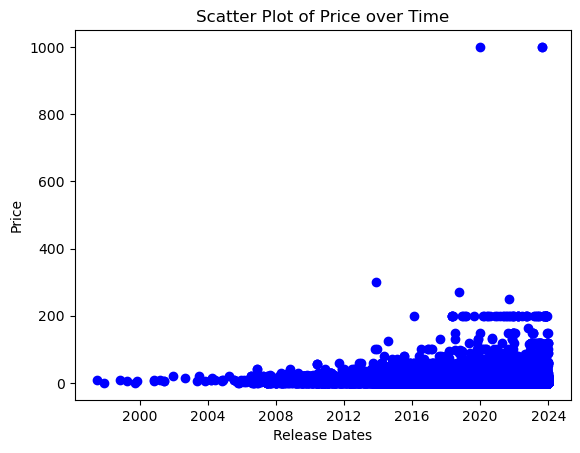

In [18]:
plt.scatter(steam_game_2['release_date'], steam_game_2['price'], color='blue')
plt.title("Scatter Plot of Price over Time")
plt.xlabel("Release Dates")
plt.ylabel("Price")
plt.show()

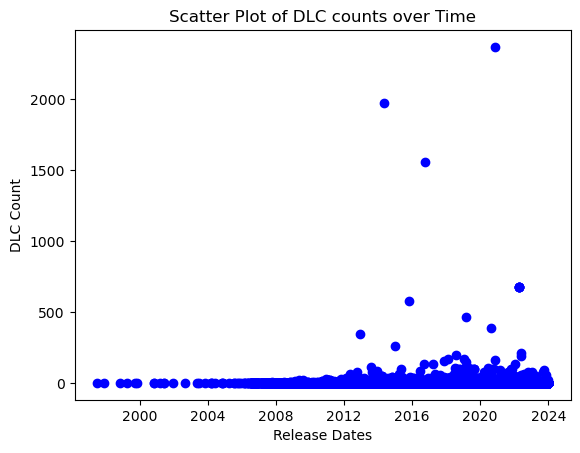

In [19]:
plt.scatter(steam_game_2['release_date'], steam_game_2['dlc_count'], color='blue')
plt.title("Scatter Plot of DLC counts over Time")
plt.xlabel("Release Dates")
plt.ylabel("DLC Count")
plt.show()

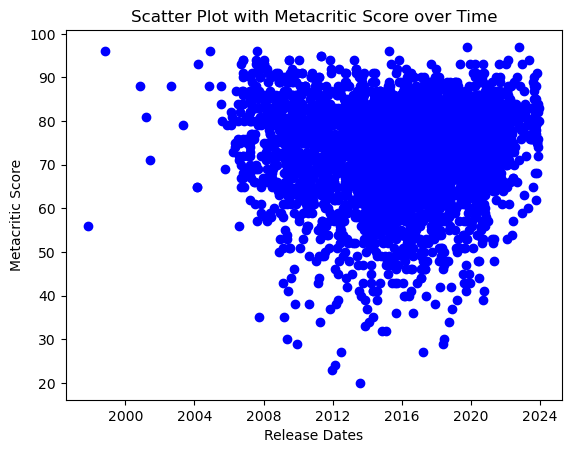

In [20]:
metacritic = steam_game_2[steam_game_2['metacritic_score'] != 0]

plt.scatter(metacritic['release_date'], metacritic['metacritic_score'], color='blue')
plt.title("Scatter Plot with Metacritic Score over Time")
plt.xlabel("Release Dates")
plt.ylabel("Metacritic Score")
plt.show()

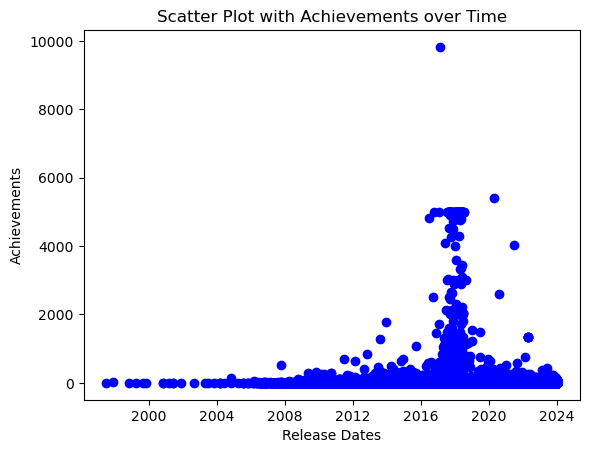

In [21]:
plt.scatter(steam_game_2['release_date'], steam_game_2['achievements'], color='blue')
plt.title("Scatter Plot with Achievements over Time")
plt.xlabel("Release Dates")
plt.ylabel("Achievements")
plt.show()

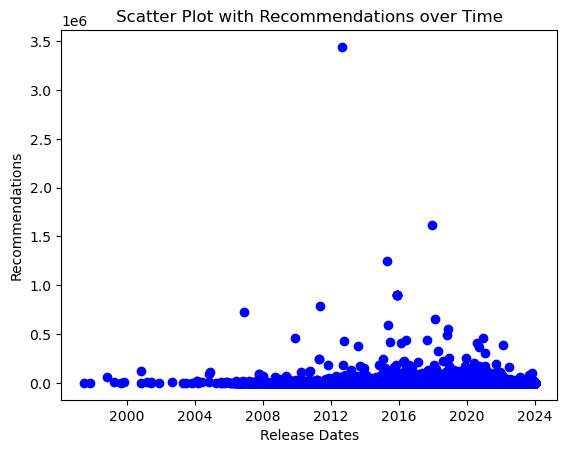

In [22]:
plt.scatter(steam_game_2['release_date'], steam_game_2['recommendations'], color='blue')
plt.title("Scatter Plot with Recommendations over Time")
plt.xlabel("Release Dates")
plt.ylabel("Recommendations")
plt.show()

In [23]:
steam_game_2[steam_game_2['recommendations'] == steam_game_2.recommendations.max()]

,name,release_date,price,dlc_count,detailed_description,about_the_game,short_description,windows,mac,linux,...,genres,positive,negative,estimated_owners,average_playtime_forever,average_playtime_2weeks,median_playtime_forever,median_playtime_2weeks,peak_ccu,tags
730,Counter-Strike: Global Offensive,2012-08-21,0.0,1,Counter-Strike: Global Offensive (CS: GO) expa...,Counter-Strike: Global Offensive (CS: GO) expa...,Counter-Strike: Global Offensive (CS: GO) expa...,True,True,True,...,"[Action, Free to Play]",5764420,766677,50000000 - 100000000,30484,777,6357,253,825215,"{'FPS': 87834, 'Shooter': 63080, 'Multiplayer'..."


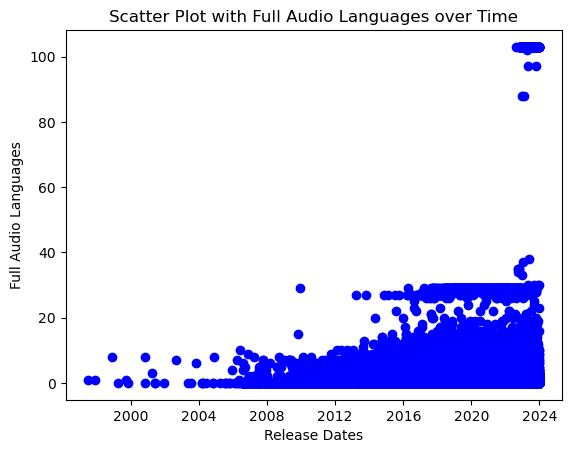

In [24]:
plt.scatter(steam_game_2['release_date'], steam_game_2['full_audio_languages'].apply(lambda x: len(x)), color='blue')
plt.title("Scatter Plot with Full Audio Languages over Time")
plt.xlabel("Release Dates")
plt.ylabel("Full Audio Languages")
plt.show()

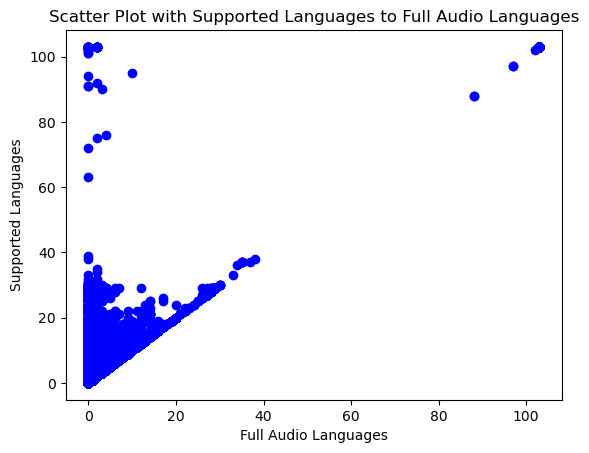

In [25]:
plt.scatter(steam_game_2['full_audio_languages'].apply(lambda x: len(x)), steam_game_2['supported_languages'].apply(lambda x: len(x)), color='blue')
plt.title("Scatter Plot with Supported Languages to Full Audio Languages")
plt.xlabel("Full Audio Languages")
plt.ylabel("Supported Languages")
plt.show()

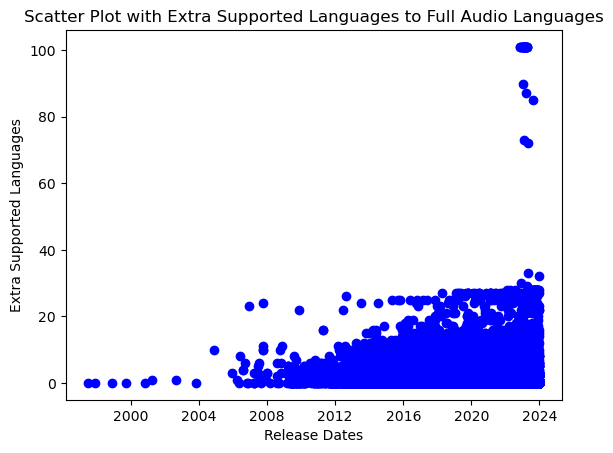

In [26]:
steam_game_2['sup_lang_num'] = steam_game_2['supported_languages'].apply(lambda x: len(x))
steam_game_2['full_audio_num'] = steam_game_2['full_audio_languages'].apply(lambda x: len(x))
steam_game_2['extra_lang_supported'] = steam_game_2['sup_lang_num'] - steam_game_2['full_audio_num']

plt.scatter(steam_game_2[steam_game_2['full_audio_num'] != 0]['release_date'], steam_game_2[steam_game_2['full_audio_num'] != 0]['extra_lang_supported'], color='blue')
plt.title("Scatter Plot with Extra Supported Languages to Full Audio Languages")
plt.xlabel("Release Dates")
plt.ylabel("Extra Supported Languages")
plt.show()

In [27]:
steam_game_2['dev_num'] = steam_game_2['developers'].apply(lambda x: len(x))
steam_game_2[steam_game_2['dev_num'] == 0]

,name,release_date,price,dlc_count,detailed_description,about_the_game,short_description,windows,mac,linux,...,average_playtime_forever,average_playtime_2weeks,median_playtime_forever,median_playtime_2weeks,peak_ccu,tags,sup_lang_num,full_audio_num,extra_lang_supported,dev_num
1943590,溪风谷之战 Playtest,2022-03-24,0.0,0,,,,True,False,False,...,0,0,0,0,0,[],0,0,0,0
1966960,Burial Stone Playtest,2022-04-13,0.0,0,,,,True,False,False,...,0,0,0,0,0,[],0,0,0,0
1688630,Emperial Knights Playtest,2021-11-14,0.0,0,,,,True,False,False,...,0,0,0,0,0,[],0,0,0,0
1478660,Slotracers VR Playtest,2020-12-17,0.0,0,,,,True,False,False,...,0,0,0,0,0,[],0,0,0,0
1613340,Pirates of the Asteroid Belt Playtest,2021-04-23,0.0,0,,,,True,False,False,...,0,0,0,0,0,[],0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2622510,PAI Playtest,2023-12-29,0.0,0,,,,True,False,False,...,0,0,0,0,0,[],0,0,0,0
2675350,咒印链接 Playtest,2023-12-25,0.0,0,,,,True,False,False,...,0,0,0,0,0,[],0,0,0,0
2343540,The Magistrate Playtest,2023-12-27,0.0,0,,,,True,False,False,...,0,0,0,0,0,[],0,0,0,0
2609050,Mobius Playtest,2023-12-25,0.0,0,,,,True,False,False,...,0,0,0,0,0,[],0,0,0,0


Looking at the developer column, some values had 0 developers. These games seem to be playtests, so I expanded the search to include all games with "Playtest" in their name.

In [28]:
steam_game_3 = steam_game_2[steam_game_2['name'].str.contains('Playtest') == False]

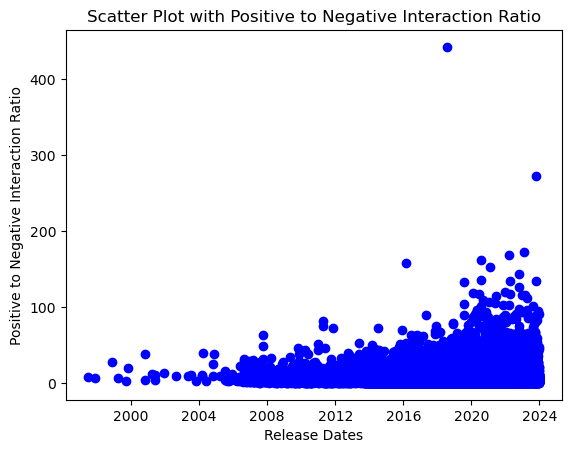

In [87]:
non_zero_interaction = steam_game_3[(steam_game_3['negative'] != 0) & (steam_game_3['positive'] != 0)]

plt.scatter(non_zero_interaction['release_date'], (non_zero_interaction['positive']+1)/(non_zero_interaction['negative']+1), color='blue')
plt.title("Scatter Plot with Positive to Negative Interaction Ratio")
plt.xlabel("Release Dates")
plt.ylabel("Positive to Negative Interaction Ratio")
plt.show()

I additionally decided to not include games with 0 positive and 0 negative reviews as these are games where so few players played that there is minimal to no interaction.

In [89]:
steam_game_3 = steam_game_3[(steam_game_3['negative'] != 0) & (steam_game_3['positive'] != 0)]

In [90]:
steam_game_3['categories'].apply(lambda x: len(x)).value_counts()

categories
1     11550
2     10008
3      7430
4      6006
5      3776
6      2566
7      1743
8      1486
9      1158
10      898
0       680
11      606
12      424
13      261
14      162
15      108
16       48
17       38
18       20
20        8
19        5
21        3
22        1
Name: count, dtype: int64

In [91]:
steam_game_3['genres'].apply(lambda x: len(x)).value_counts()

genres
3     14356
2     13634
4      7997
1      7305
5      3570
6      1377
7       449
8       150
0        58
9        58
10       20
11        9
16        1
13        1
Name: count, dtype: int64

In [92]:
steam_game_3['tags'].apply(lambda x: len(x)).value_counts()

tags
20    15618
5      3385
4      3099
3      2957
6      2735
7      2223
8      1904
9      1638
2      1577
10     1537
11     1437
13     1339
16     1313
12     1285
17     1275
15     1260
14     1238
18     1231
19     1166
1       487
21      277
0         4
Name: count, dtype: int64

In [93]:
steam_game_3['estimated_owners'].value_counts()

estimated_owners
0 - 20000                31839
20000 - 50000             6987
50000 - 100000            3642
100000 - 200000           2490
200000 - 500000           2120
500000 - 1000000           904
1000000 - 2000000          518
2000000 - 5000000          329
5000000 - 10000000          92
10000000 - 20000000         38
20000000 - 50000000         21
50000000 - 100000000         4
100000000 - 200000000        1
Name: count, dtype: int64

In [94]:
steam_game_3.columns

Index(['name', 'release_date', 'price', 'dlc_count', 'detailed_description',
       'about_the_game', 'short_description', 'windows', 'mac', 'linux',
       'metacritic_score', 'achievements', 'recommendations',
       'supported_languages', 'full_audio_languages', 'developers',
       'publishers', 'categories', 'genres', 'positive', 'negative',
       'estimated_owners', 'average_playtime_forever',
       'average_playtime_2weeks', 'median_playtime_forever',
       'median_playtime_2weeks', 'peak_ccu', 'tags', 'sup_lang_num',
       'full_audio_num', 'extra_lang_supported', 'dev_num'],
      dtype='object')

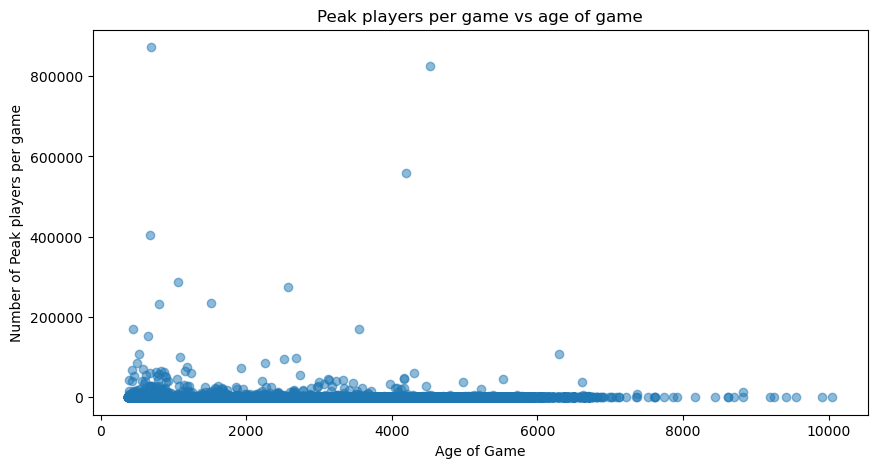

In [95]:
# Plot the number of games released each year
plt.figure(figsize=(10, 5))
plt.scatter((pd.Timestamp.today() - steam_game_3['release_date']).dt.days, steam_game_3['peak_ccu'], alpha = 0.5)
plt.xlabel('Age of Game')
plt.ylabel('Number of Peak players per game')
plt.title('Peak players per game vs age of game')
plt.show()

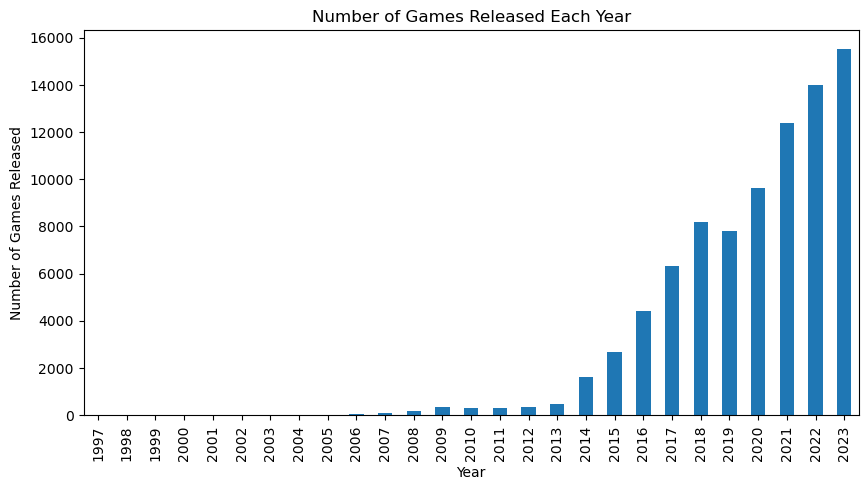

In [96]:
# Extract the year from the release_date column
steam_game_2.loc[:, 'release_year'] = steam_game_2['release_date'].dt.year

# Count the number of games released each year
games_per_year = steam_game_2['release_year'].value_counts().sort_index()

# Plot the number of games released each year
plt.figure(figsize=(10, 5))
games_per_year.plot(kind = 'bar')
plt.xlabel('Year')
plt.ylabel('Number of Games Released')
plt.title('Number of Games Released Each Year')
plt.show()

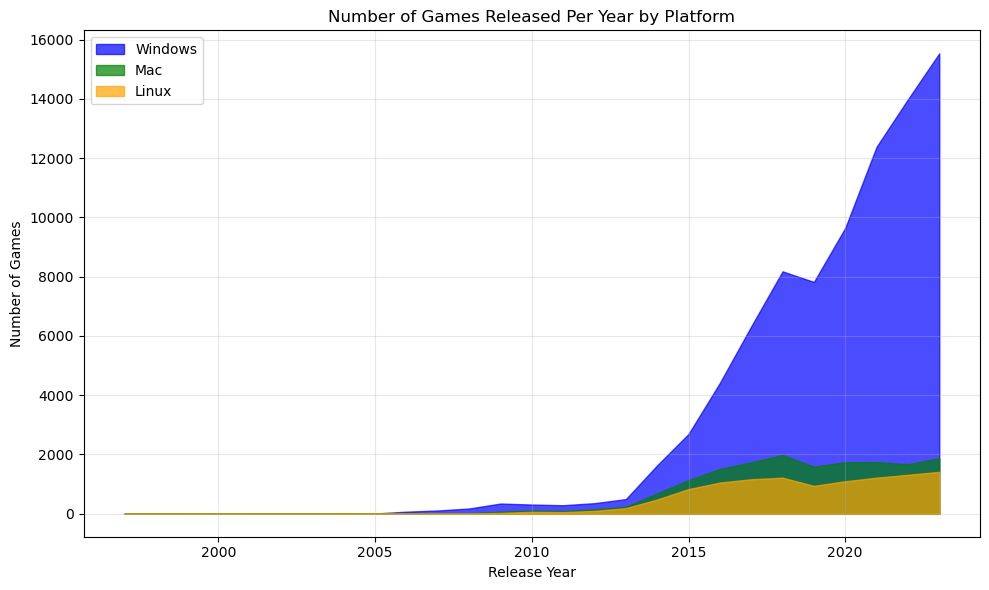

In [97]:
op_sys = steam_game_2.groupby('release_year')[['windows', 'mac', 'linux']].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.fill_between(op_sys['release_year'], 0, op_sys['windows'], 
        label='Windows', color='blue', alpha = 0.7)
plt.fill_between(op_sys['release_year'], 0, op_sys['mac'],
        label='Mac', color='green', alpha = 0.7)
plt.fill_between(op_sys['release_year'], 0, op_sys['linux'], 
        label='Linux', color='orange', alpha = 0.7)

plt.title('Number of Games Released Per Year by Platform')
plt.xlabel('Release Year')
plt.ylabel('Number of Games')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

There is a general increasing trend in games released on Steam. This coincides with the general movement of games being released on CD to online downloads. However, it looks like windows games continue to dominate the scene, with Mac games being edged out while linux maintains consistent slow growth.

In [100]:
steam_game_3.columns

Index(['name', 'release_date', 'price', 'dlc_count', 'detailed_description',
       'about_the_game', 'short_description', 'windows', 'mac', 'linux',
       'metacritic_score', 'achievements', 'recommendations',
       'supported_languages', 'full_audio_languages', 'developers',
       'publishers', 'categories', 'genres', 'positive', 'negative',
       'estimated_owners', 'average_playtime_forever',
       'average_playtime_2weeks', 'median_playtime_forever',
       'median_playtime_2weeks', 'peak_ccu', 'tags', 'sup_lang_num',
       'full_audio_num', 'extra_lang_supported', 'dev_num'],
      dtype='object')

In [101]:
steam_game_3.to_csv('steam_game_cleaned.csv', index = False)